# 1. Build an image segmentation model using pytorch

In [ ]:
# Importing libraries

import os
import numpy as np
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/Project3_CV

/content/drive/My Drive/Project3_CV


In [ ]:
!ls

'Project Three.ipynb'   Test   Train


In [ ]:
# Transforms

train_trans = A.Compose(
    [
        A.Resize(256, 256),
        A.ColorJitter(p=0.2),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)
test_trans = A.Compose(
    [
        A.Resize(224,224),
        ToTensorV2(),
    ],
)

In [ ]:
# Creating dataset

class LungDataset(Dataset):
    def __init__(self, input_dir, output_dir, is_train, transform=None):
        self.input_dir  = input_dir
        self.output_dir = output_dir
        self.transform  = transform
        if is_train == True:
            x = round(len(os.listdir(input_dir)) * .9)
            self.images = os.listdir(input_dir)[:x]
        else:
            x = round(len(os.listdir(input_dir)) * .9)
            self.images = os.listdir(input_dir)[x:]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path    = os.path.join(self.input_dir, self.images[index])
        mask_path   = os.path.join(self.output_dir, self.images[index])
        img         = np.array(Image.open(img_path).convert("L"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)  / 255
        
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"]
        
        return img, mask

In [ ]:
# Data Loading

img_dir = './Train/Images'
mask_dir = './Train/Masks'

train_dataset = LungDataset(img_dir, mask_dir, is_train=True, transform =train_trans)
valid_dataset = LungDataset(img_dir, mask_dir, is_train=False, transform =test_trans)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
)

In [ ]:
# Using GPU

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
class UNet(nn.Module):
    
    def __init__(self,num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=1, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [ ]:
model = UNet(num_classes=1).to(device)

# 2. Train your model using [lung segmentation datasets](https://github.com/YoushanZhang/Lung_Segmentation)

In [ ]:
# Calculating IoU score

class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU

In [ ]:
iou = IoULoss()

In [ ]:
lr = 0.0001
def train_fn(loader, model):
    loop = tqdm(loader)
    loss_fn   = nn.CrossEntropyLoss()
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    model.train()

    for batch_idx, (image, mask) in enumerate(loop):
        image   = image.to(device)
        mask    = mask.float().unsqueeze(1).to(device)

        # forward
        predictions = model(image)
        loss = loss_fn(predictions, mask)

        # backward
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [ ]:
epochs    = 10
loss_fn   = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

valacc=[]
valloss=[]
for epoch in range(epochs):

    print('epoch: '+str(epoch))
    # train the model
    train_fn(train_data_loader, model)
    
    # validation check
    valid_loss = 0
    model.eval()
    with torch.no_grad():
        for img, mask in tqdm(valid_data_loader):
            mask  = mask.to(device).unsqueeze(1)
            out = model(img.to(device))
            loss = loss_fn(out,mask)
            valid_loss += loss.item()
            ret, predictions = torch.max(out.data, 1)
            mask = mask.squeeze(1)
            IOU =iou(mask, predictions)
        
        else:
            valloss.append(valid_loss/len(valid_data_loader))
            valacc.append(IOU)
        
            # print accuracy and loss
            print('IOU Score', IOU)
            print(f"Validation loss: {valid_loss/len(valid_data_loader)}") 
print("Learning Finished")
torch.save(model, 'UNET.pt')

epoch: 0


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


IOU Score tensor(2.2037e-06, device='cuda:0')
Validation loss: 0.301249223947525
epoch: 1


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


IOU Score tensor(2.2037e-06, device='cuda:0')
Validation loss: 0.19175445437431335
epoch: 2


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


IOU Score tensor(2.2037e-06, device='cuda:0')
Validation loss: 0.10651984363794327
epoch: 3


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


IOU Score tensor(2.2037e-06, device='cuda:0')
Validation loss: 0.10479960739612579
epoch: 4


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


IOU Score tensor(2.2037e-06, device='cuda:0')
Validation loss: 0.09955503791570663
epoch: 5


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


IOU Score tensor(2.2037e-06, device='cuda:0')
Validation loss: 0.09292681664228439
epoch: 6


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


IOU Score tensor(2.2037e-06, device='cuda:0')
Validation loss: 0.08989912420511245
epoch: 7


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


IOU Score tensor(2.2037e-06, device='cuda:0')
Validation loss: 0.09031344801187516
epoch: 8


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


IOU Score tensor(2.2037e-06, device='cuda:0')
Validation loss: 0.09531539380550384
epoch: 9


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


IOU Score tensor(2.2037e-06, device='cuda:0')
Validation loss: 0.08607747107744217
Learning Finished


# 3.Evaluate your model using the test images

TypeError: ignored

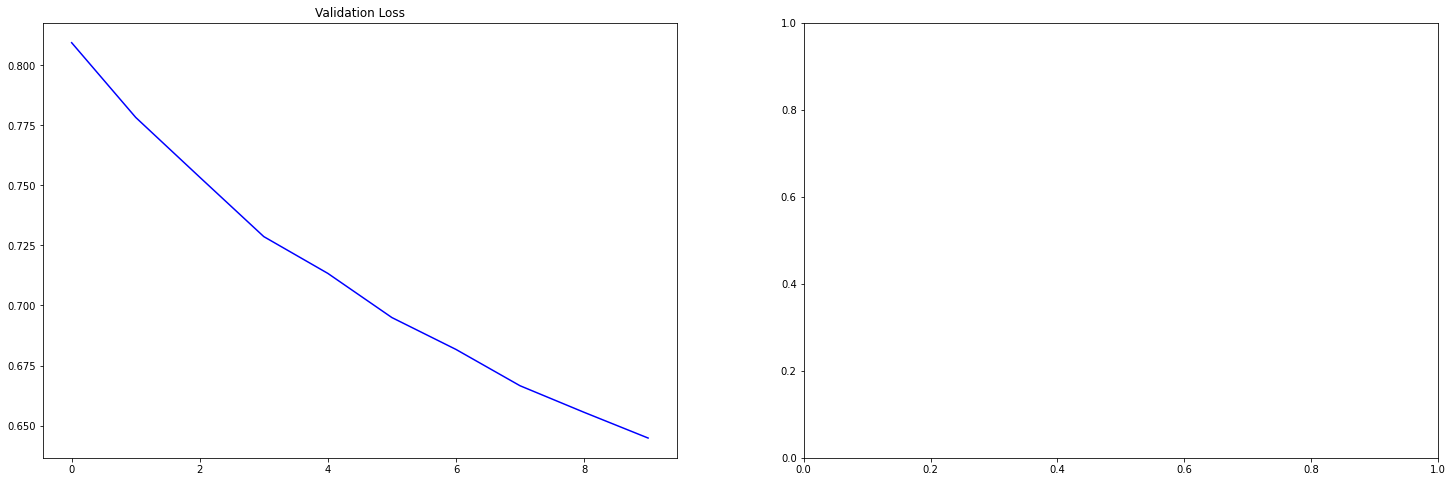

In [ ]:
e = [i for i in range(0,epochs)]
plt.figure(figsize =(25,8))
plt.subplot(1,2,1)
plt.plot(e, valloss, c='b')
plt.title('Validation Loss')

plt.subplot(1,2,2)
plt.plot(e, valacc, c='b')
plt.title('Validation IOU Score')

# 4. Your IoU score should be higher than 0.82

In [ ]:
test_img_dir = 'Test/Images/'
test_mask_dir = 'Test/Masks/'

test_dataset = LungDataset( test_img_dir, test_mask_dir, is_train=True, transform=test_trans)
test_data_loader = DataLoader( test_dataset, batch_size=16, shuffle=True, num_workers=4 )

with torch.no_grad():
    for img, mask in tqdm(test_data_loader):
        mask  = mask.to(device).unsqueeze(1)
        out = model(img.to(device))
        ret, predictions = torch.max(out.data, 1)
    IOU =iou(mask, predictions)
    print("Test IOU score:", IOU)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 12/12 [00:05<00:00,  2.36it/s]

Test IOU score: tensor(8.8000e-06, device='cuda:0')



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# 5. Write a two-page report using LaTex and upload your paper to ResearchGate or Arxiv. 
